In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from datetime import datetime
import random
import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.optimizers.legacy import Nadam
from tensorflow.keras.optimizers import AdamW
#from tensorflow.keras.optimizers.legacy import AdamW

from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer, Masking
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, regularizers
from keras.callbacks import EarlyStopping

In [3]:
sns.set_theme(rc={'figure.figsize':(16,8)})

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
from google.colab import files
uploaded = files.upload()

Saving 01_06_2021_to_20_06_2023_prepared_df_25.csv to 01_06_2021_to_20_06_2023_prepared_df_25 (1).csv


In [5]:
df_25 = pd.read_csv('01_06_2021_to_20_06_2023_prepared_df_25.csv', parse_dates=[0], index_col=[0])
df_25

,nb_cars,nb_cars_cxl,nb_bookings,nb_bookings_cxl,hourly rate,WE package,1 week package,1 month package,other package,2 weeks package,...,12H à 15H,0H à 6H,18H à 24H,+24h,06:00 24:00,00:30 06:00,00:00 00:30,strike,holidays,vacation
date,,,,,,,,,,,,,,,,,,,,,
2021-06-01,6,0,5,0,1,0,4,1,0,0,...,2,1,1,6,0,0,0,0,0,0
2021-06-02,10,0,13,0,3,0,6,1,0,0,...,2,1,1,10,0,0,0,0,0,0
2021-06-03,15,0,6,0,7,0,7,1,0,0,...,2,1,1,15,0,0,0,0,0,0
2021-06-04,18,0,15,0,10,0,7,1,0,0,...,3,2,1,18,0,0,0,0,0,0
2021-06-05,18,0,5,1,6,9,3,0,0,0,...,8,0,0,18,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-16,37,4,32,4,21,3,11,2,0,0,...,9,3,0,37,0,0,0,0,0,0
2023-06-17,41,6,11,0,7,24,8,2,0,0,...,18,0,1,41,0,0,0,0,0,0
2023-06-18,40,5,2,0,3,26,7,4,0,0,...,14,0,1,40,0,0,0,0,0,0


In [167]:
# This function will create a slice of data from a specified random starting position.
# The random position must be generated externally.

def get_Xi_yi(df_X,
              df_y,
              random_start,
              X_length=56,
              y_length=14):

#     must define a random_start:int for function to run
    Xi = df_X.iloc[random_start-X_length:random_start]
    yi = df_y.iloc[random_start:random_start+y_length]

    return Xi, yi


In [168]:
# The main data selection function.
# This function will generate all random slices based on the length of the dataframe passed.
# Important to note, if val state is set to true, it will only generate data slices after the val_cutoff point.

def get_X_y(df,
            X_length=56,
            y_length=14,
            number_of_sequences=51,
            number_of_targets=1,
            n_pca=25,
            val=False,
            val_cutoff=0.8):

#     limit dataframes to length for train/test splits
    df_X = df.copy()
    df_y = df.iloc[:, :number_of_targets].copy()

#     convert and scale X dataframe to PCA to solve dimensionality problem
    scaler = MinMaxScaler()
    df_X_scaled = scaler.fit_transform(df_X)
    pca = PCA(n_components=n_pca).fit(df_X_scaled)
    df_X_proj = pd.DataFrame(pca.transform(df_X_scaled))
    df_X_proj.index = df_X.index

#     create unique list to sample random datapoints from
    if val:
        sample_list = list(range(int(len(df_y)*val_cutoff), int(len(df_y)-y_length)))
    if not val:
        sample_list = list(range(int(X_length), int(len(df_y)-y_length)))
    random.shuffle(sample_list)

#     empty lists to append data to, will create 3D dataframe here
    X, y = [], []

#     for loop to select ith values from data
    for i in range(number_of_sequences):
        Xi, yi = get_Xi_yi(df_X_proj, df_y, sample_list.pop(-1), X_length, y_length)
        X.append(Xi.values.tolist())
        y.append(yi.values.tolist())

    return np.array(X), np.array(y)

In [211]:
# Create X_train, y_train
tgv_X_train, tgv_y_train = get_X_y(df_25.iloc[:int(len(df_25)*0.6)],
                            X_length=56,
                            y_length=14,
                            number_of_sequences=75,
                            number_of_targets=1)

In [212]:
tgv_y_train = tgv_y_train[:, :, 0]


In [213]:
print(tgv_X_train.shape, tgv_y_train.shape)

(75, 56, 25) (75, 14)


In [214]:
# Define X_val, y_val
tgv_X_val, tgv_y_val = get_X_y(df_25.iloc[:int(len(df_25)*0.8)],
                       X_length=56,
                       y_length=14,
                       number_of_sequences=30,
                       number_of_targets=1,
                       val=True,
                       val_cutoff=0.6)

In [215]:
tgv_y_val = tgv_y_val[:, :, 0]

In [216]:
print(tgv_X_val.shape, tgv_y_val.shape)

(30, 56, 25) (30, 14)


In [217]:
# Define X_test, y_tes
tgv_X_test, tgv_y_test = get_X_y(df_25,
                         X_length=56,
                         y_length=14,
                         number_of_sequences=15,
                         number_of_targets=1,
                         val=True,
                         val_cutoff=0.8)

In [218]:
tgv_y_test =tgv_y_test[:, :, 0]

In [219]:
print(tgv_X_test.shape, tgv_y_test.shape)

(15, 56, 25) (15, 14)


In [220]:
# y normalize
tgv_y_scaler = MinMaxScaler()
tgv_y_scaler.fit(np.log(tgv_y_train))

tgv_y_train_scaled = tgv_y_scaler.transform(np.log(tgv_y_train))
tgv_y_test_scaled = tgv_y_scaler.transform(np.log(tgv_y_test))
tgv_y_val_scaled = tgv_y_scaler.transform(np.log(tgv_y_val))

In [221]:
tgv_input_shape = tgv_X_train.shape[1:]
tgv_output_shape = tgv_y_train_scaled.shape[1]
tgv_reg = regularizers.l1_l2(l1=0.04, l2=0.02)

In [222]:
# instantiate model
tgv_model = Sequential()

# masking
#tgv_model.add(layers.Masking(mask_value=-1000, input_shape = (56, 30)))

# model.add(Masking(input_shape = input_shape))
#tgv_input_shape

# hidden layer architecture
tgv_model.add(LSTM(200, return_sequences=True,\
              input_shape = tgv_input_shape))

tgv_model.add(LSTM(200, return_sequences=True,
               recurrent_regularizer=tgv_reg,
              # dropout=0.2
              ))

tgv_model.add(LSTM(200, return_sequences=True,
               recurrent_regularizer=tgv_reg,
              # dropout=0.2
              ))

tgv_model.add(LSTM(200, return_sequences=True,
               recurrent_regularizer=tgv_reg,
              # dropout=0.2
              ))

# pass final sequences
tgv_model.add(LSTM(200, return_sequences=False))

#can add dense layer
#droput layers/ recurrent dropout
#regularizers

# prediction layer
tgv_model.add(Dense(tgv_output_shape, activation = 'linear'))

In [223]:
optimizer = AdamW(learning_rate=0.001,
                  beta_1=0.8,
                  beta_2=0.999)
    #learning_rate=0.00003,
                 # beta_1=0.8,
                  #epsilon=1e-18)

In [224]:
tgv_model.compile(
    loss=['logcosh'],
    metrics=['mae','mape'],
    optimizer=optimizer
)

es = EarlyStopping(
    patience=10,
    restore_best_weights=True
)

tgv_history = tgv_model.fit(
                tgv_X_train,
                tgv_y_train_scaled,
                batch_size = 32,
                epochs = 500,
                shuffle = False,
                verbose = 2,
                validation_data = (tgv_X_val, tgv_y_val_scaled),
                callbacks=[es]
)

Epoch 1/500
3/3 - 11s - loss: 540.0488 - mae: 0.6114 - mape: 367956.8750 - val_loss: 497.2901 - val_mae: 0.6130 - val_mape: 80.5793 - 11s/epoch - 4s/step
Epoch 2/500
3/3 - 0s - loss: 484.4251 - mae: 0.4498 - mape: 6001872.0000 - val_loss: 444.8777 - val_mae: 0.1682 - val_mape: 22.0983 - 138ms/epoch - 46ms/step
Epoch 3/500
3/3 - 0s - loss: 433.0212 - mae: 0.1881 - mape: 5275361.0000 - val_loss: 396.5770 - val_mae: 0.2080 - val_mape: 27.1472 - 128ms/epoch - 43ms/step
Epoch 4/500
3/3 - 0s - loss: 385.6721 - mae: 0.1859 - mape: 8421033.0000 - val_loss: 352.1007 - val_mae: 0.2004 - val_mape: 25.2487 - 127ms/epoch - 42ms/step
Epoch 5/500
3/3 - 0s - loss: 342.0697 - mae: 0.1579 - mape: 8143653.5000 - val_loss: 311.3618 - val_mae: 0.1621 - val_mape: 20.8431 - 108ms/epoch - 36ms/step
Epoch 6/500
3/3 - 0s - loss: 302.1970 - mae: 0.1480 - mape: 8695350.0000 - val_loss: 274.0690 - val_mae: 0.1439 - val_mape: 18.7232 - 105ms/epoch - 35ms/step
Epoch 7/500
3/3 - 0s - loss: 265.7227 - mae: 0.1386 - ma

In [225]:
tgv_y_pred = tgv_model.predict(tgv_X_test)

tgv_y_pred = tgv_y_scaler.inverse_transform(tgv_y_pred)
tgv_y_pred = np.exp(tgv_y_pred)

1/1 [==============================] - 2s 2s/step


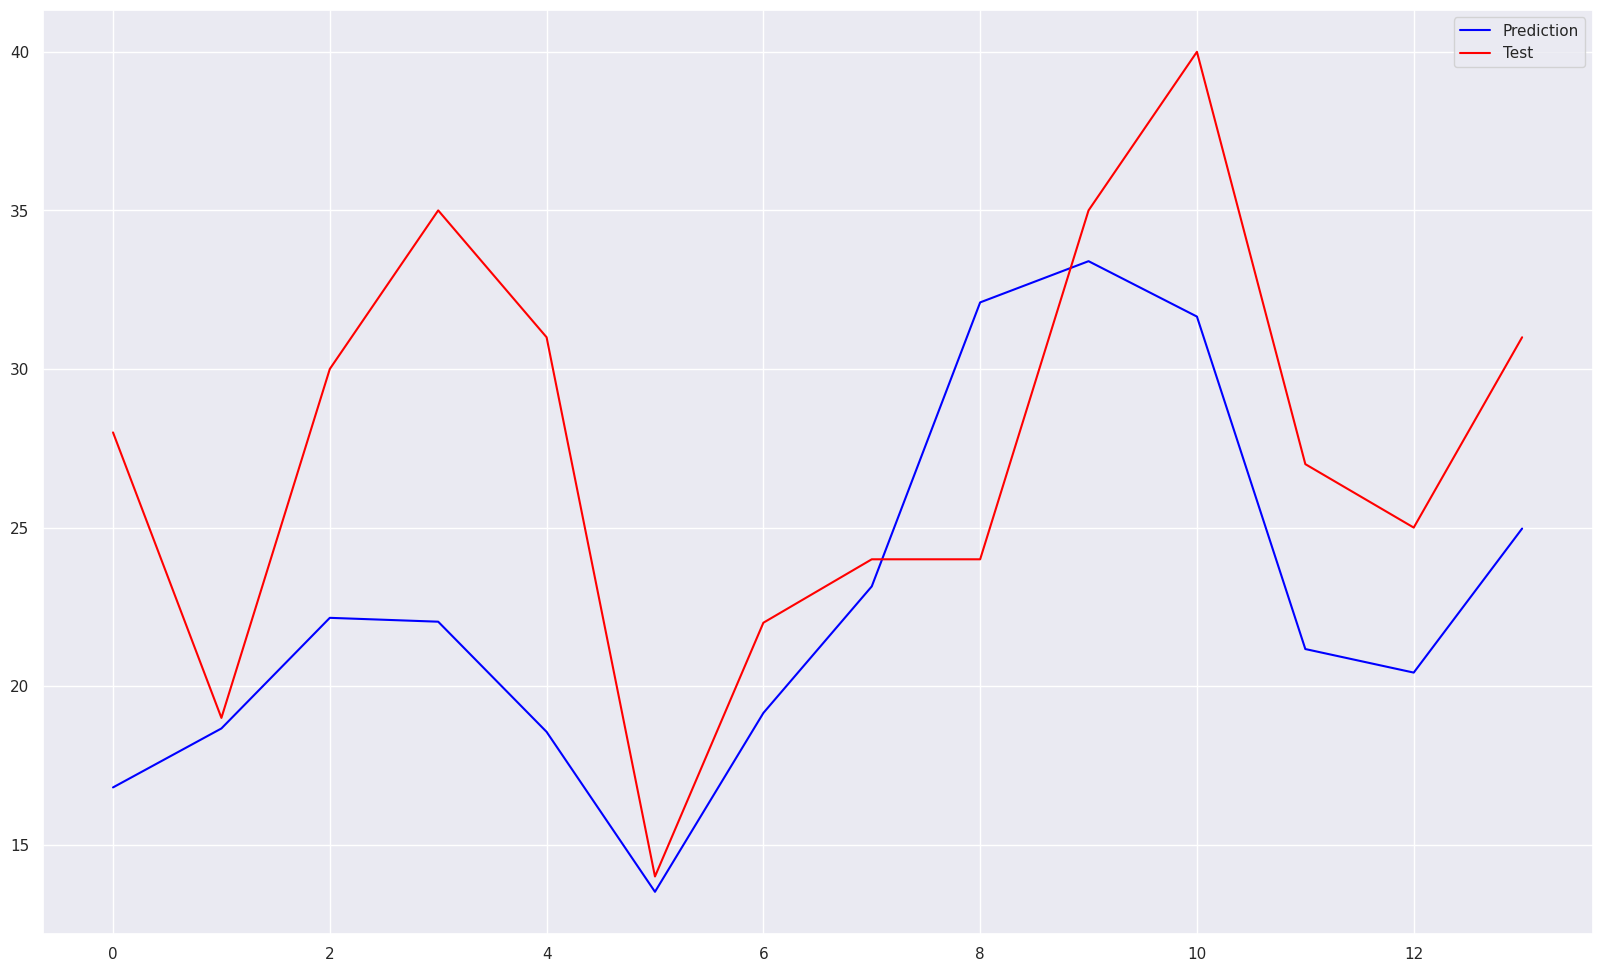

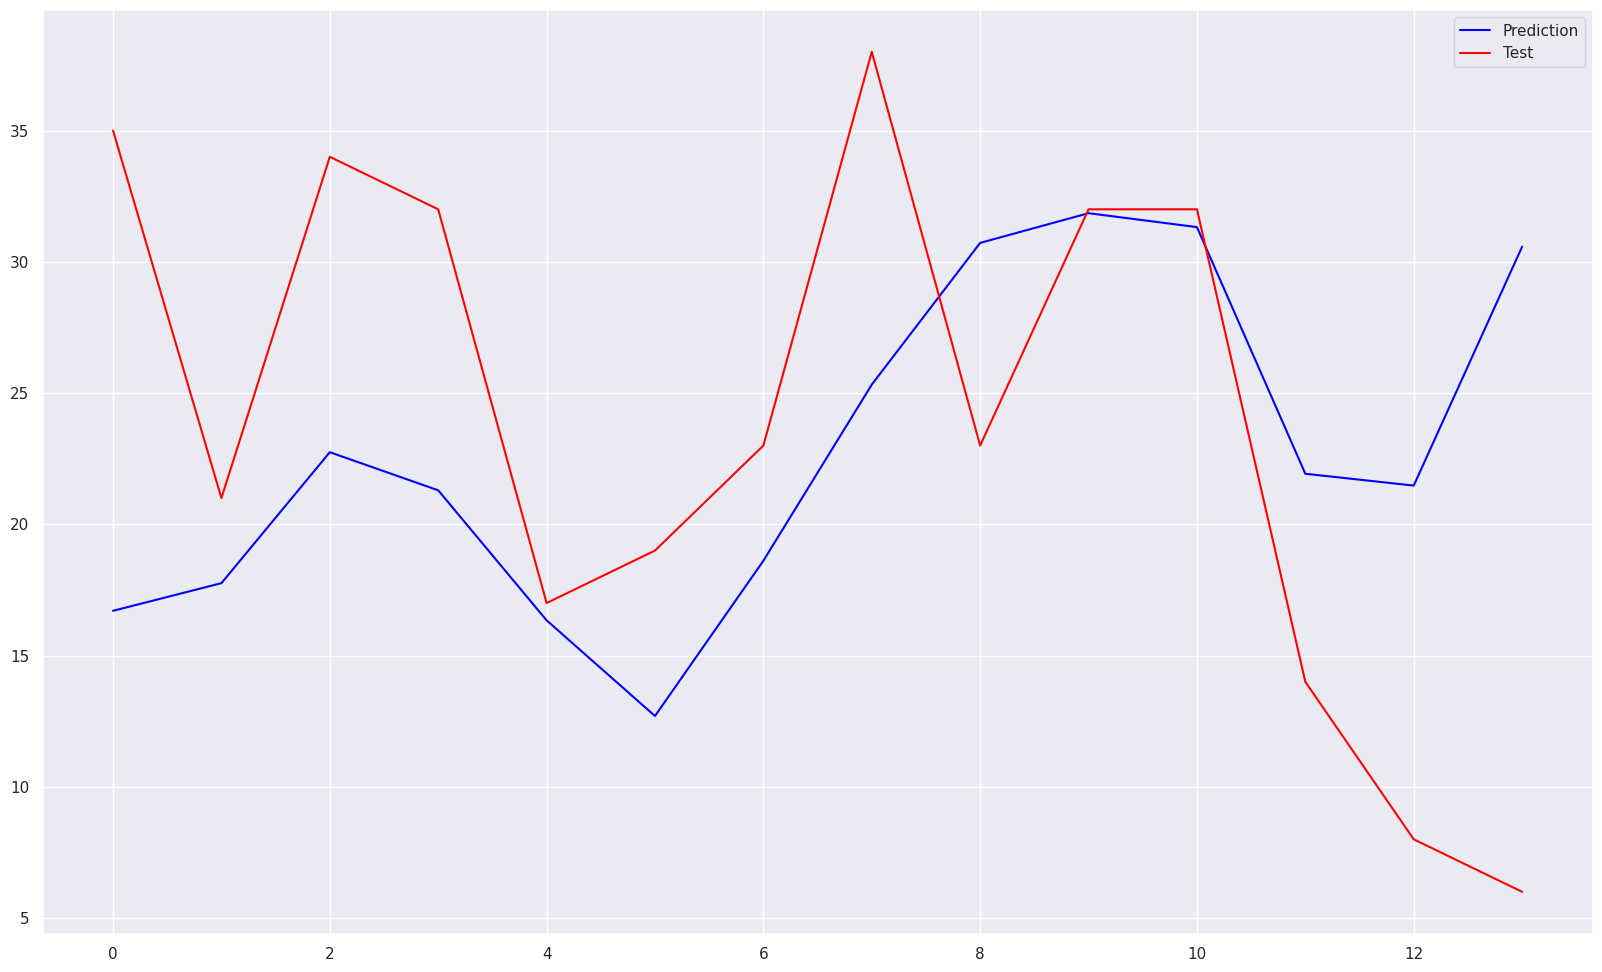

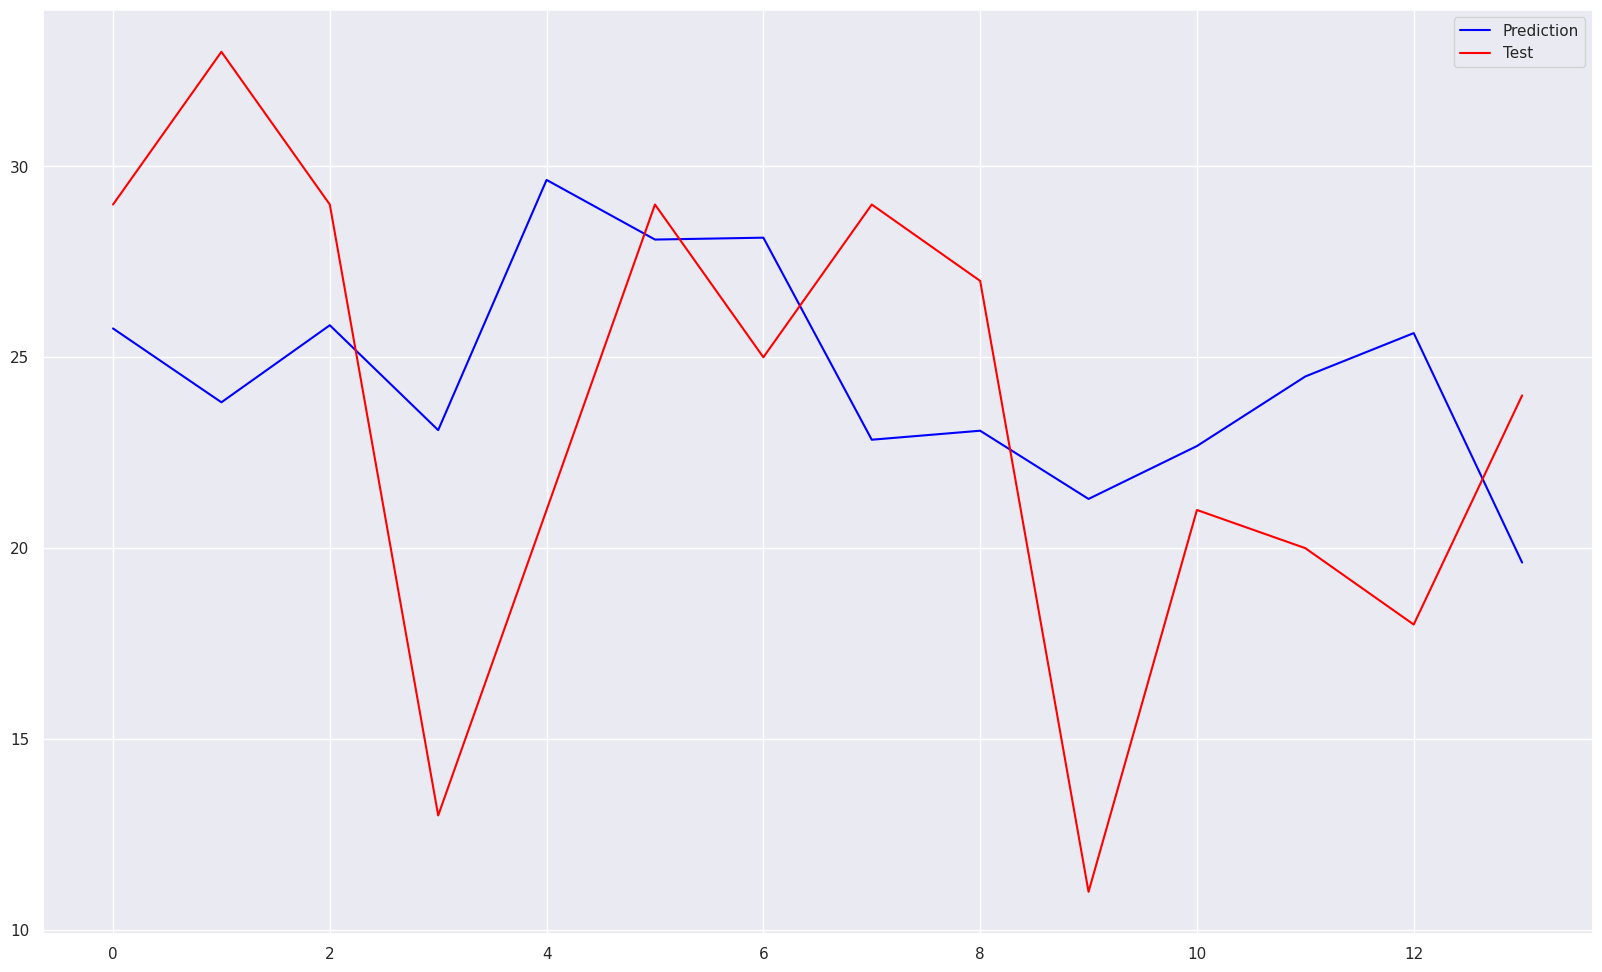

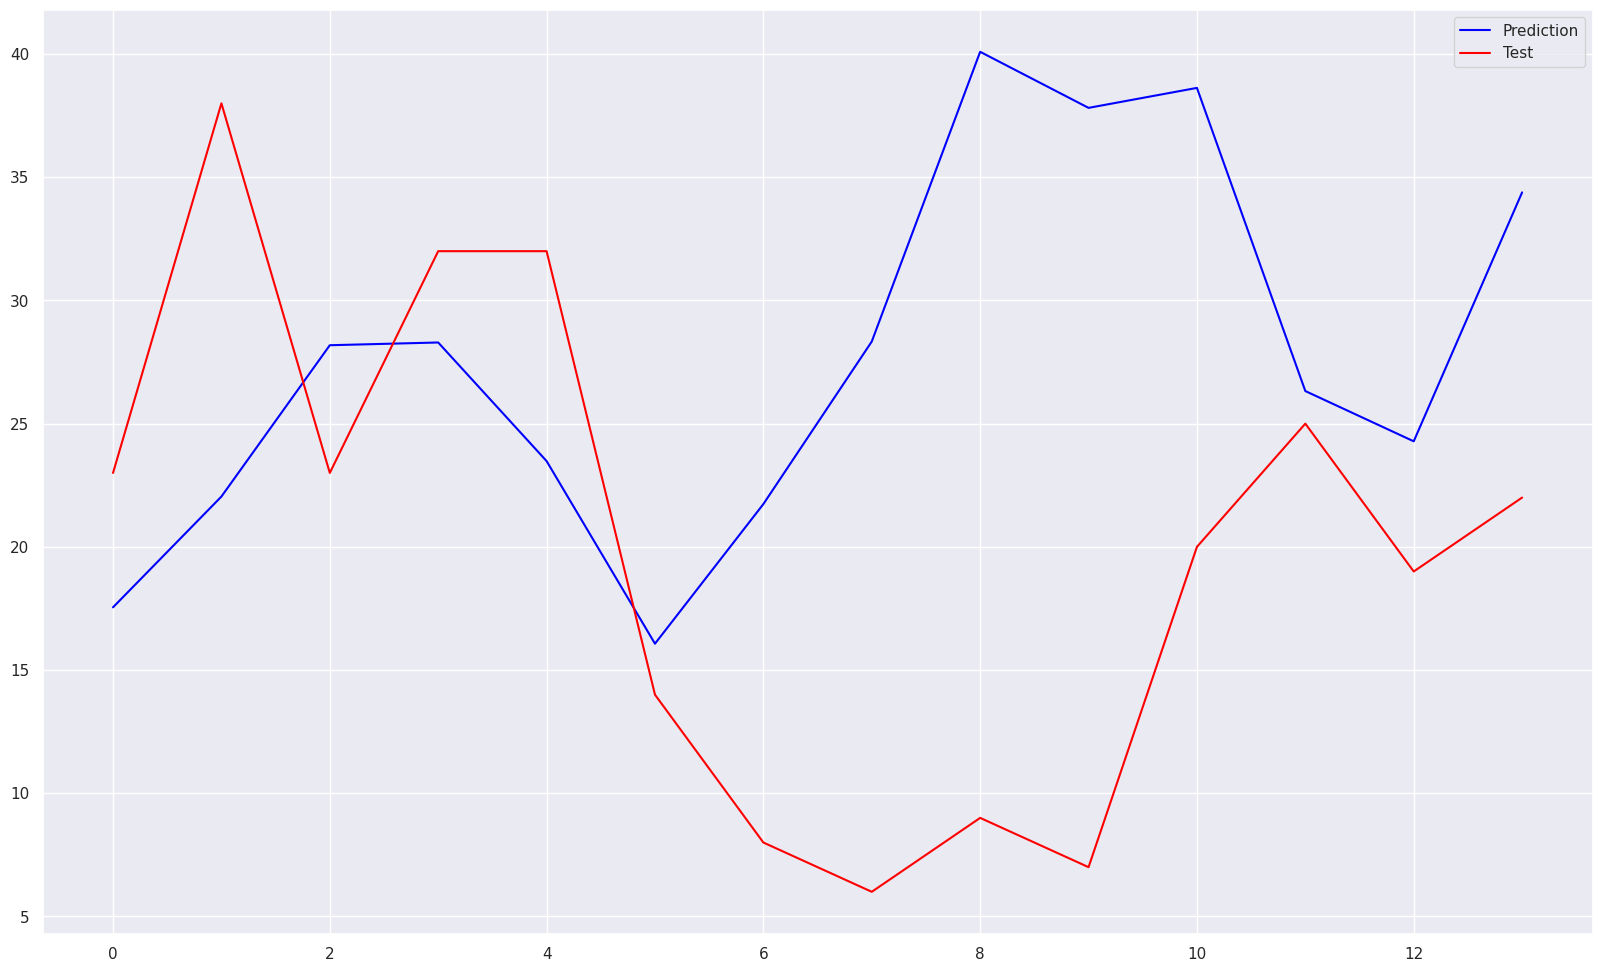

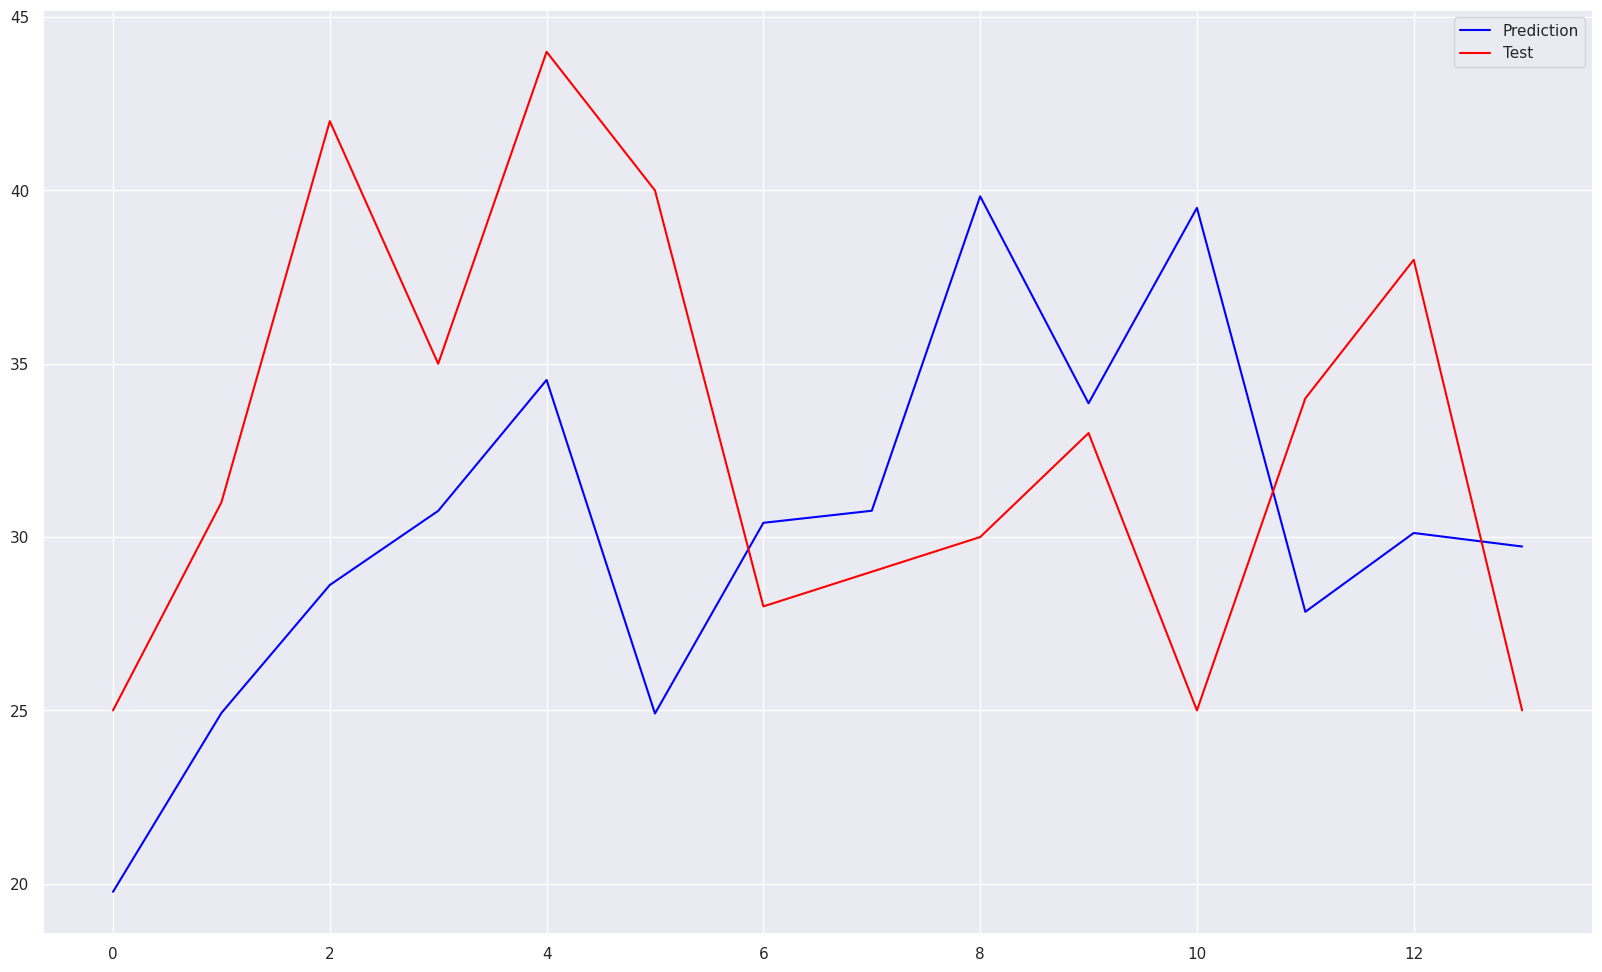

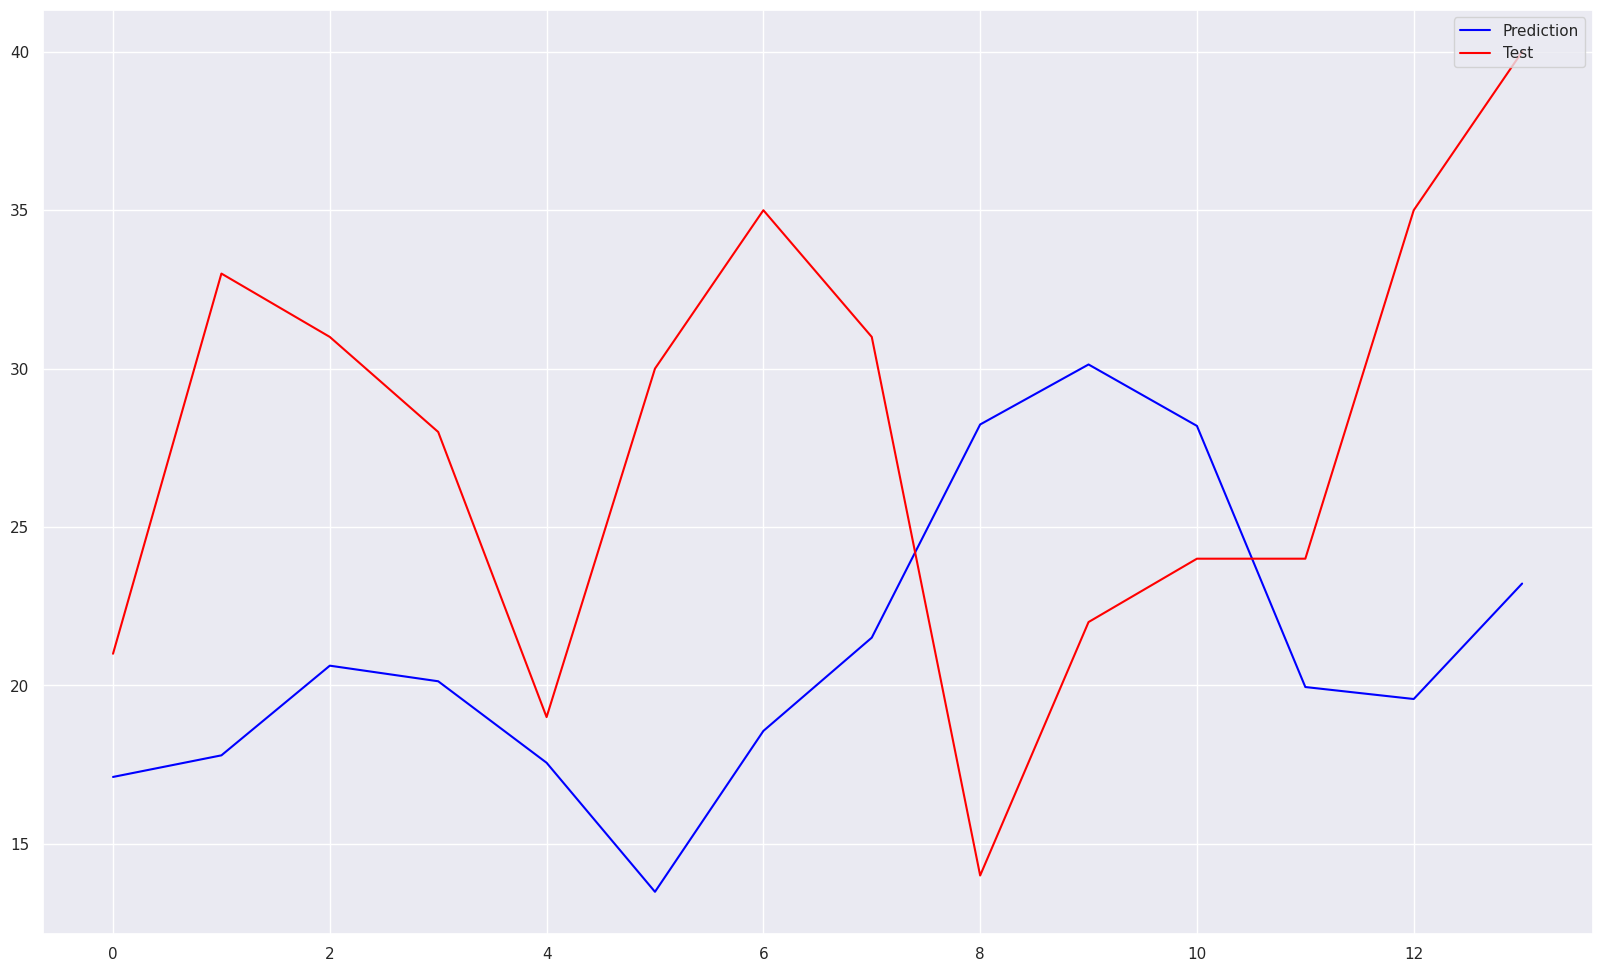

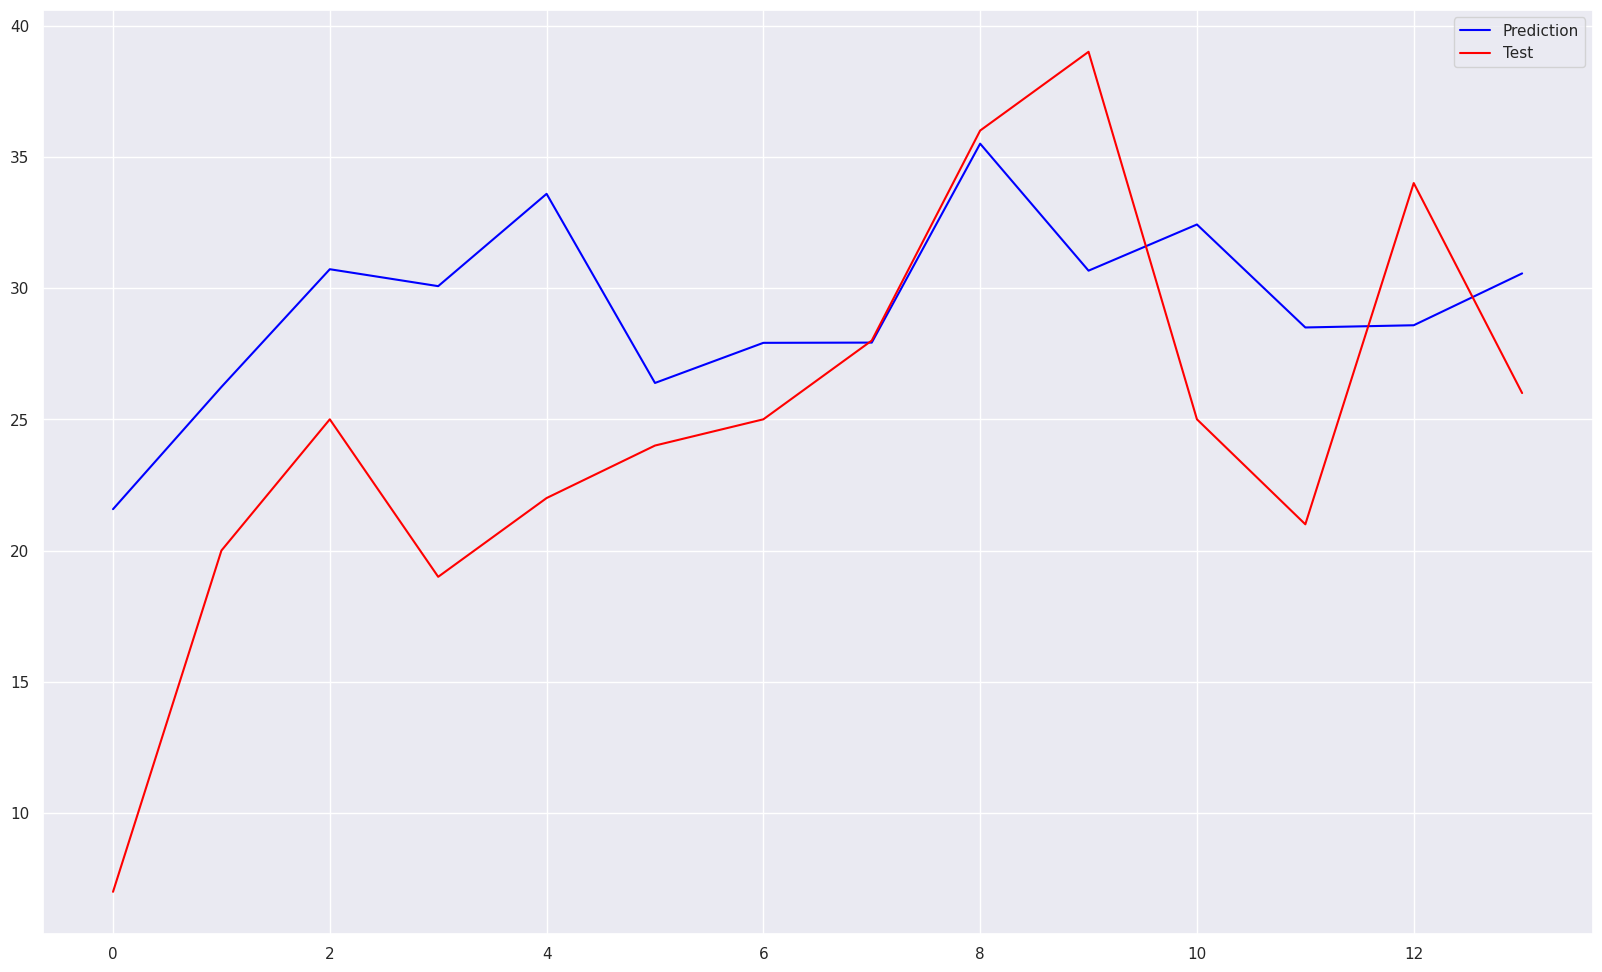

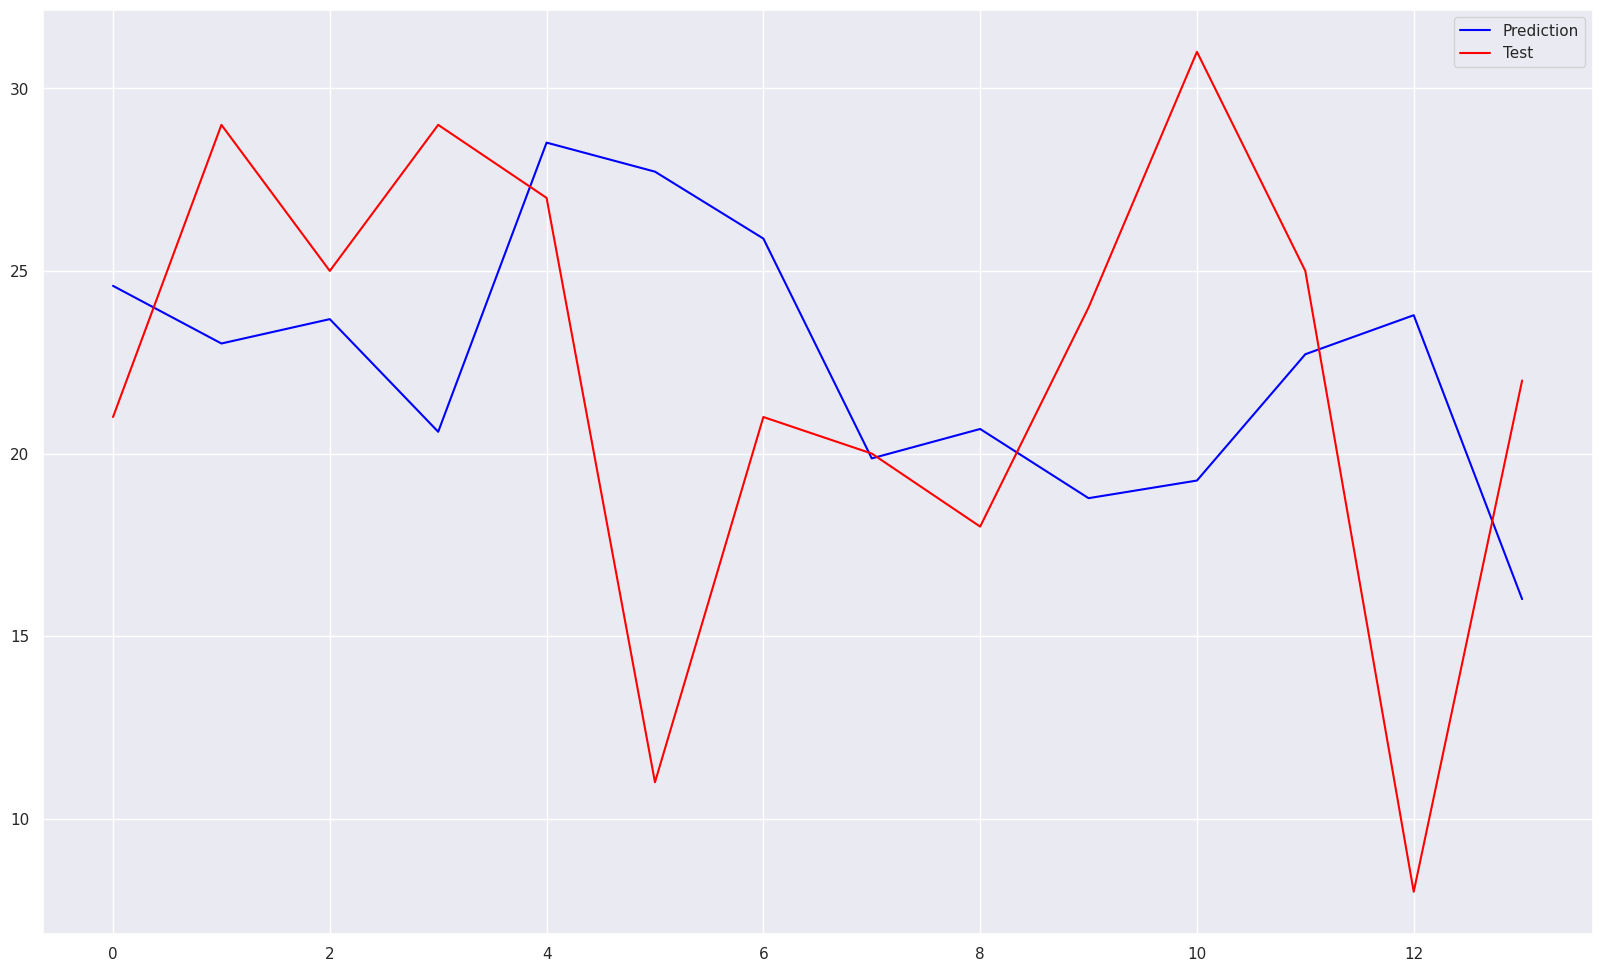

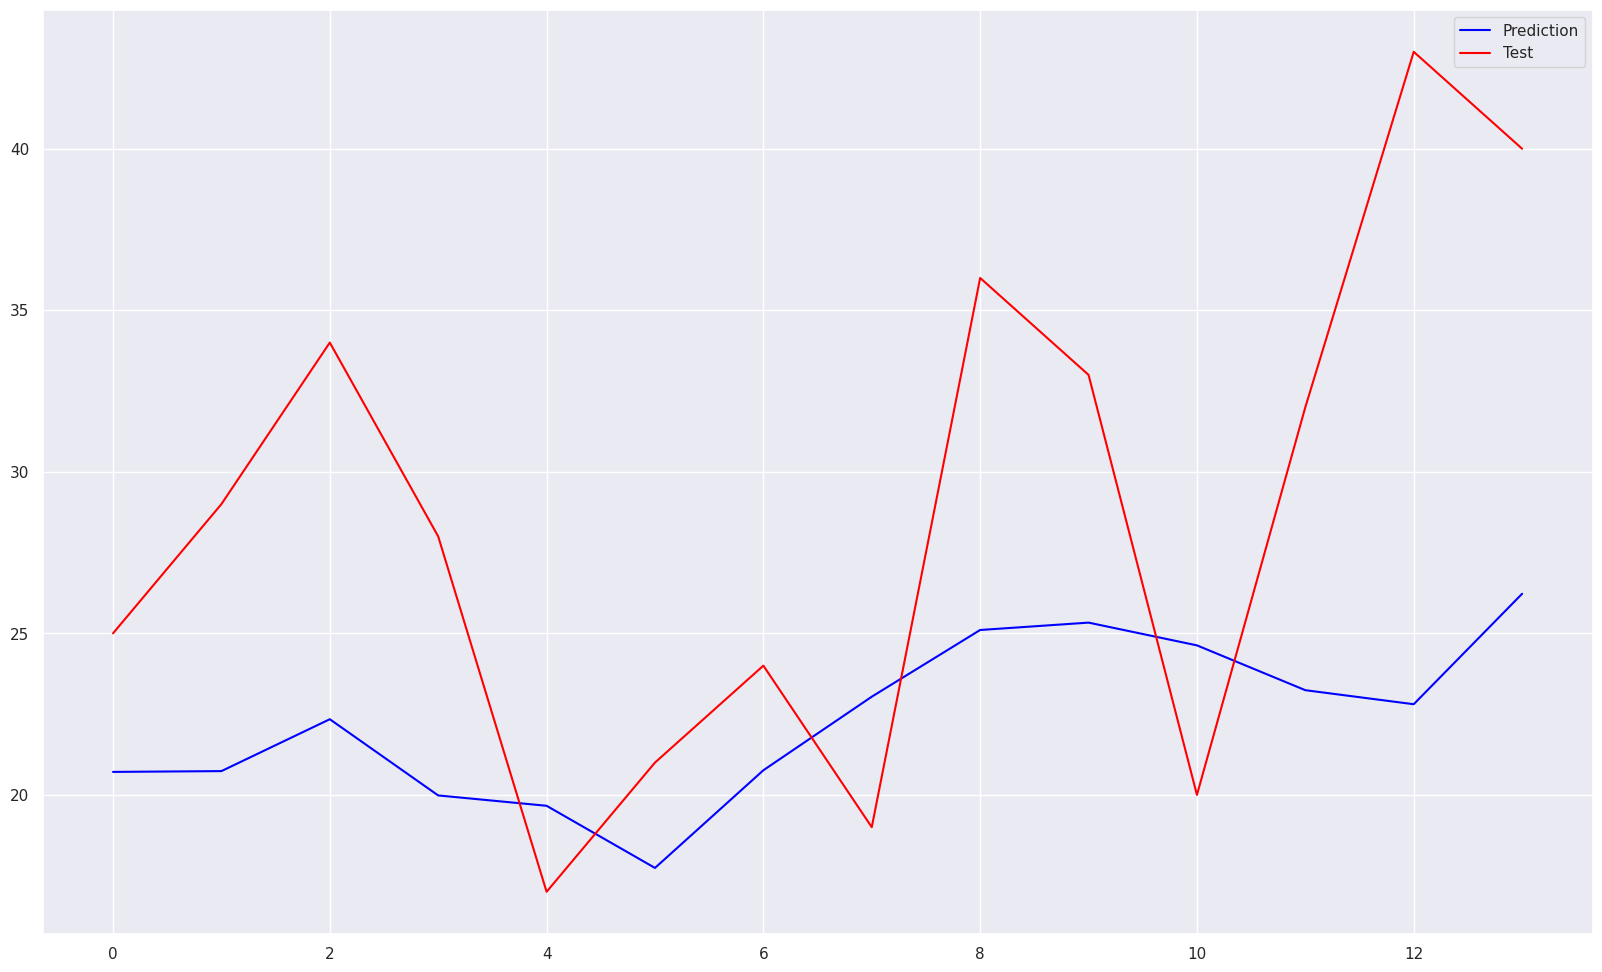

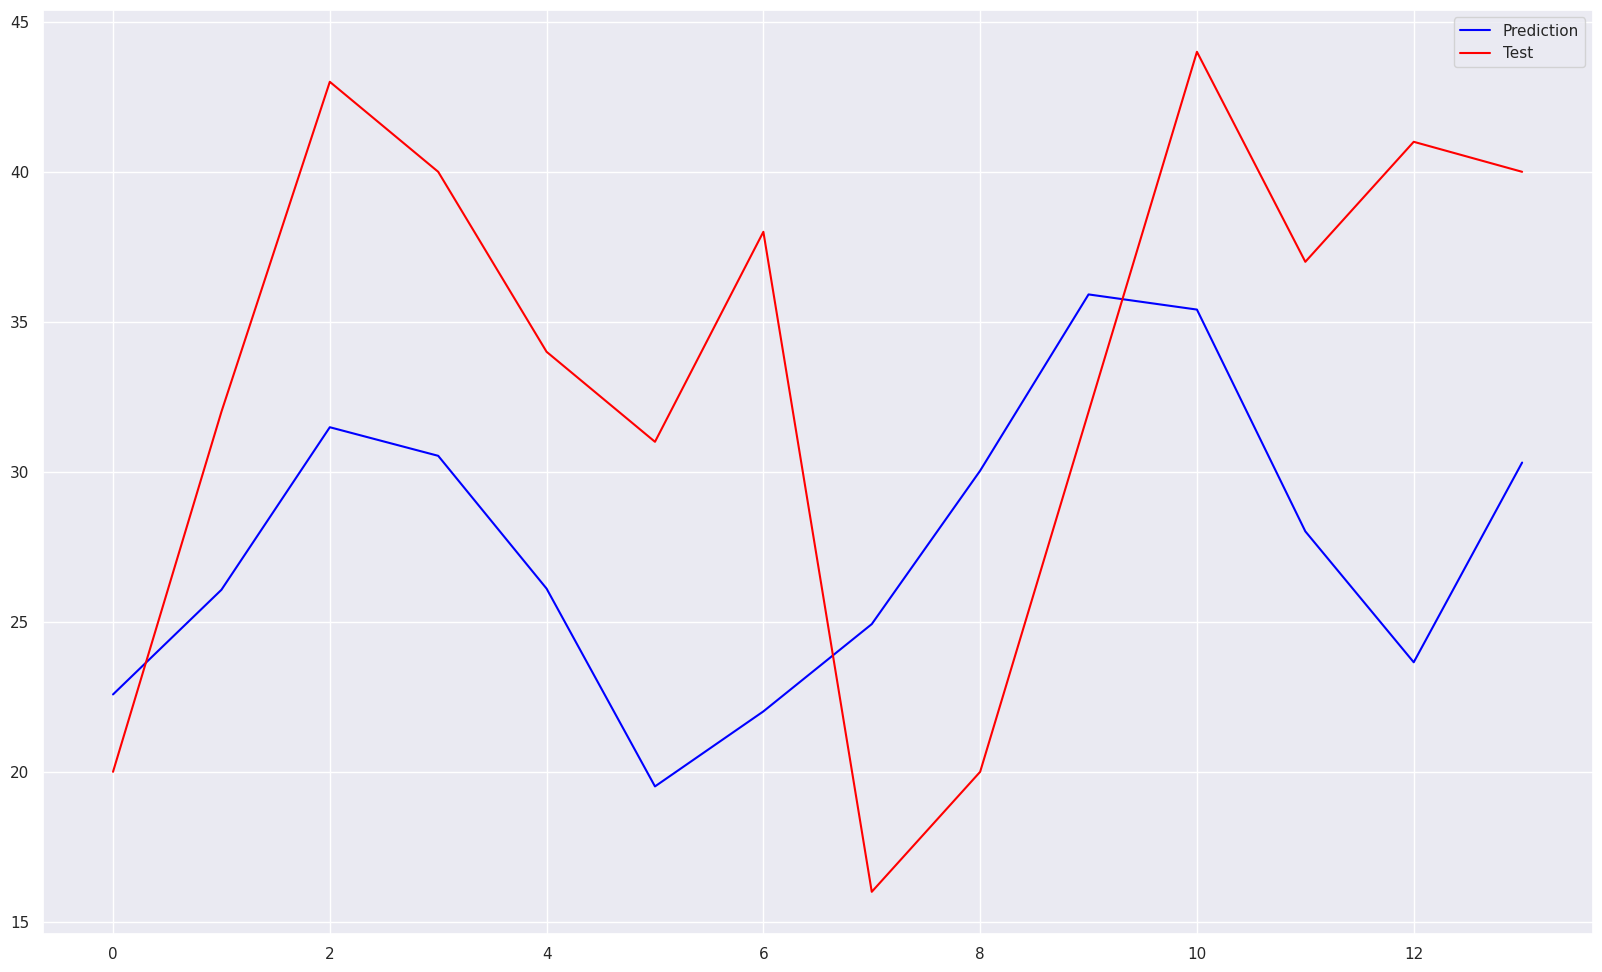

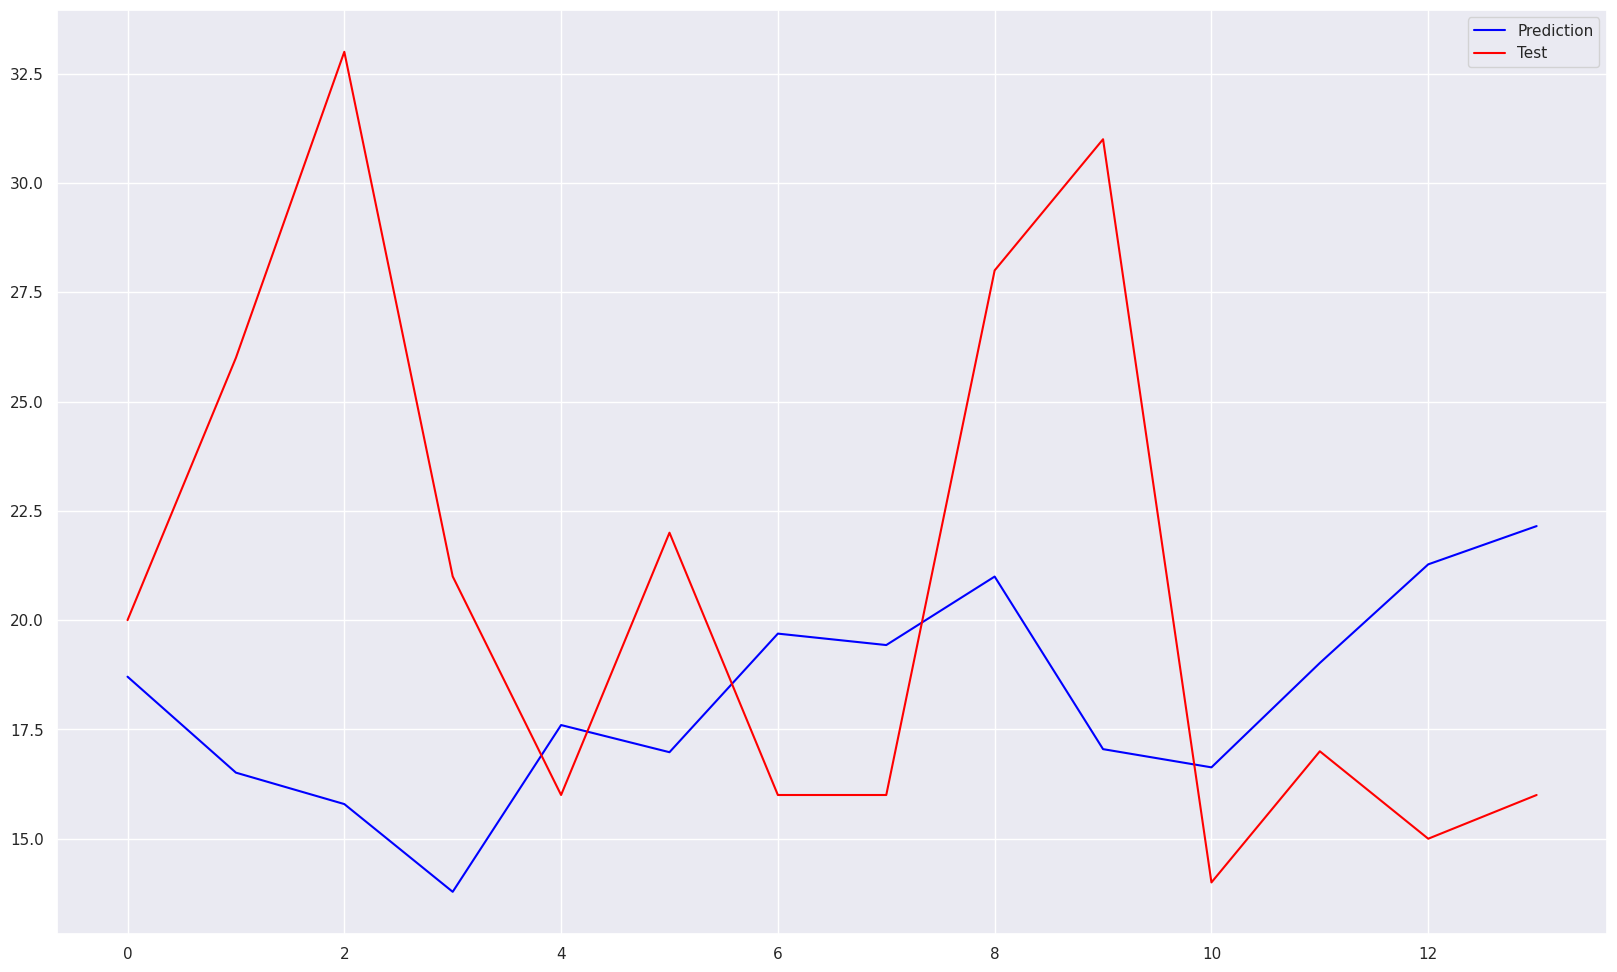

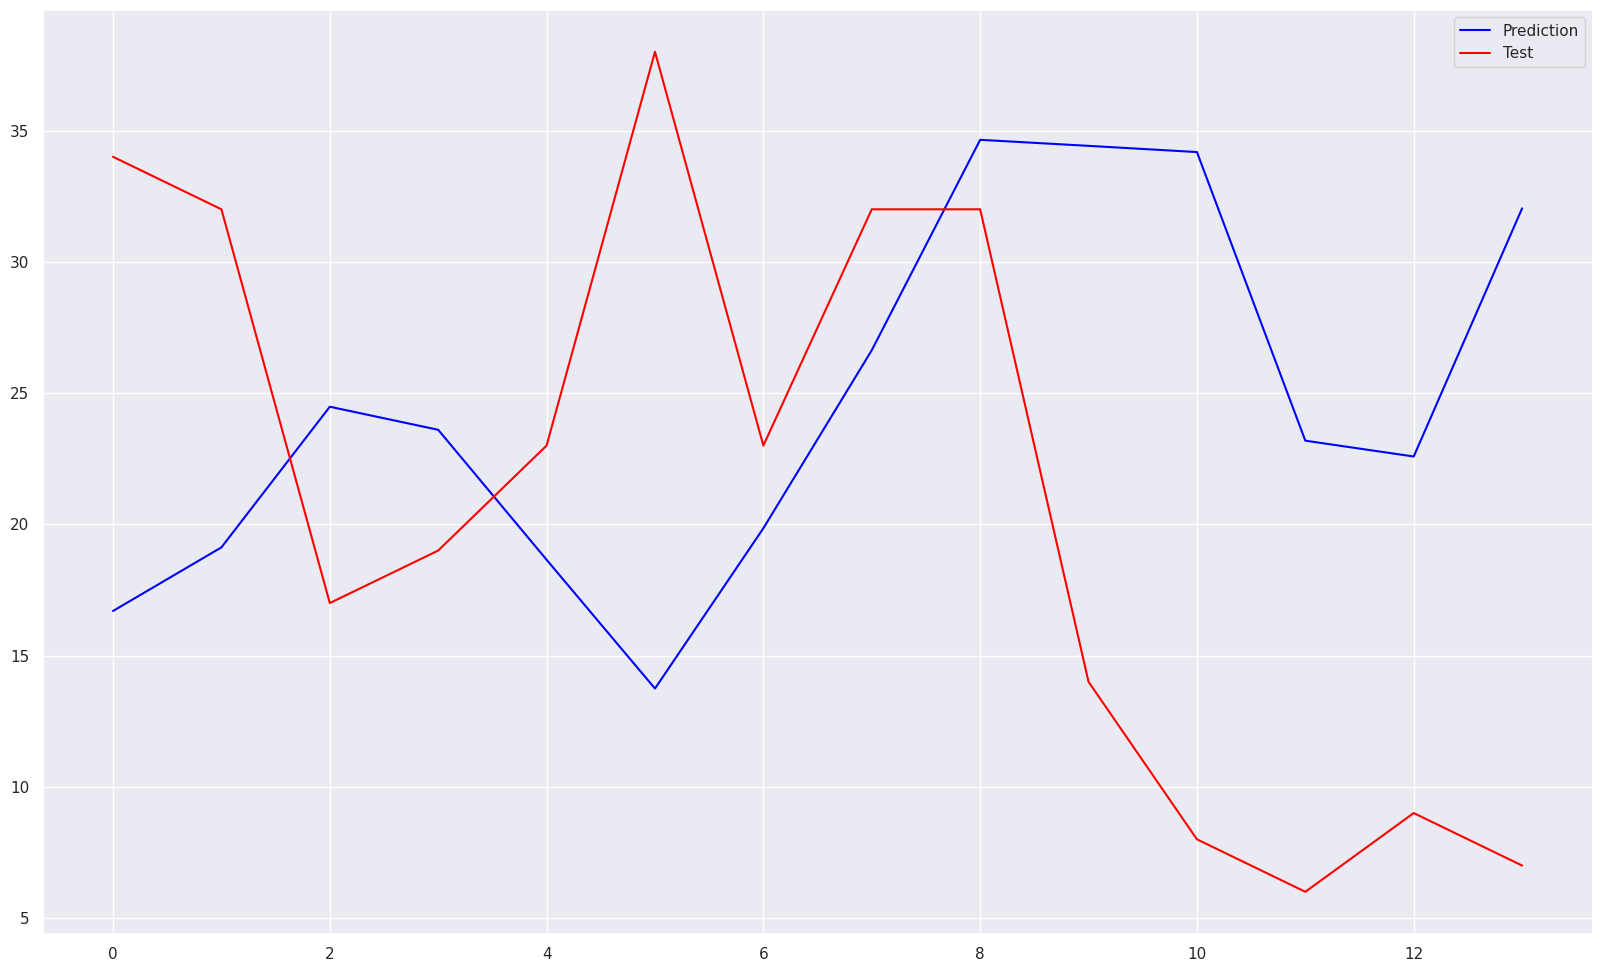

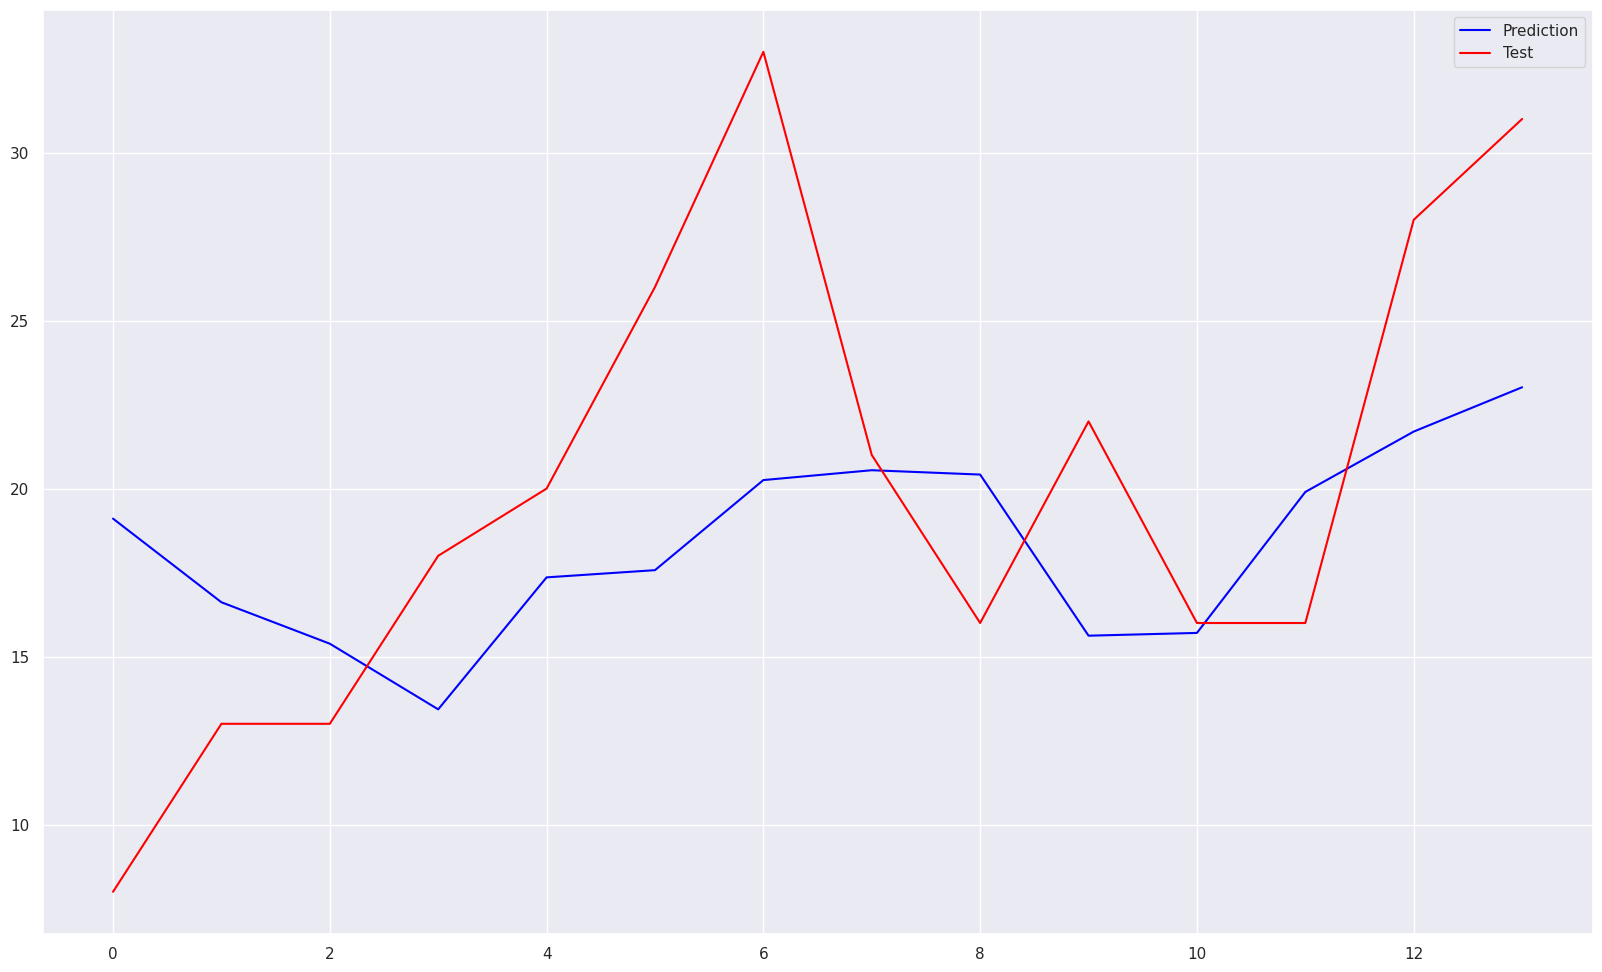

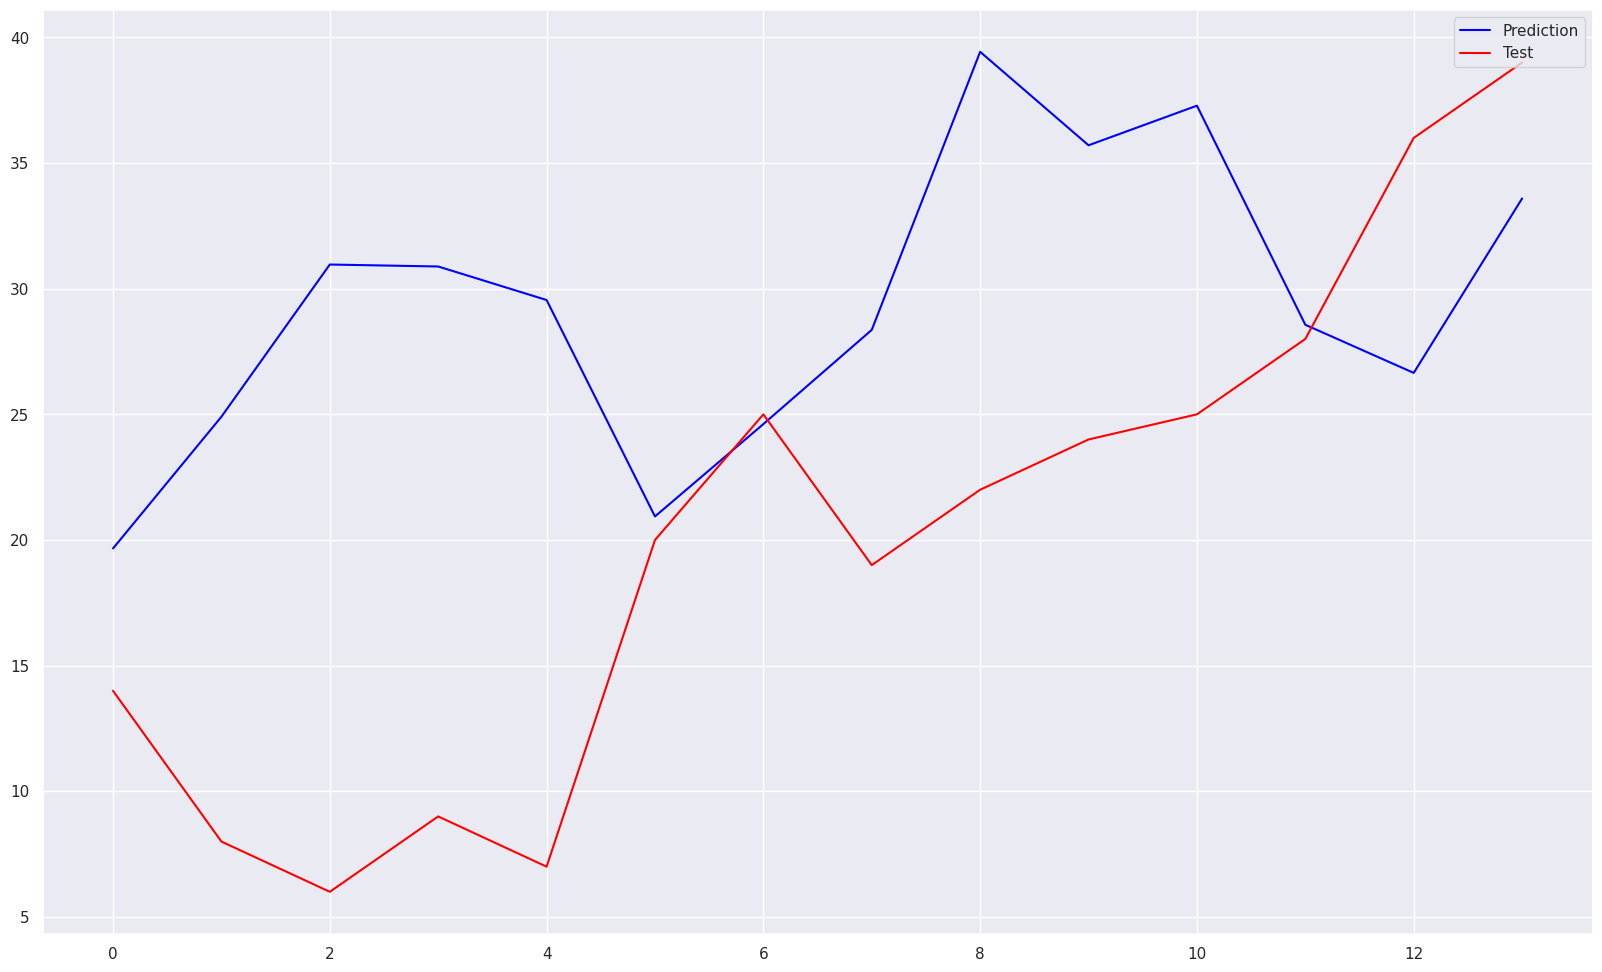

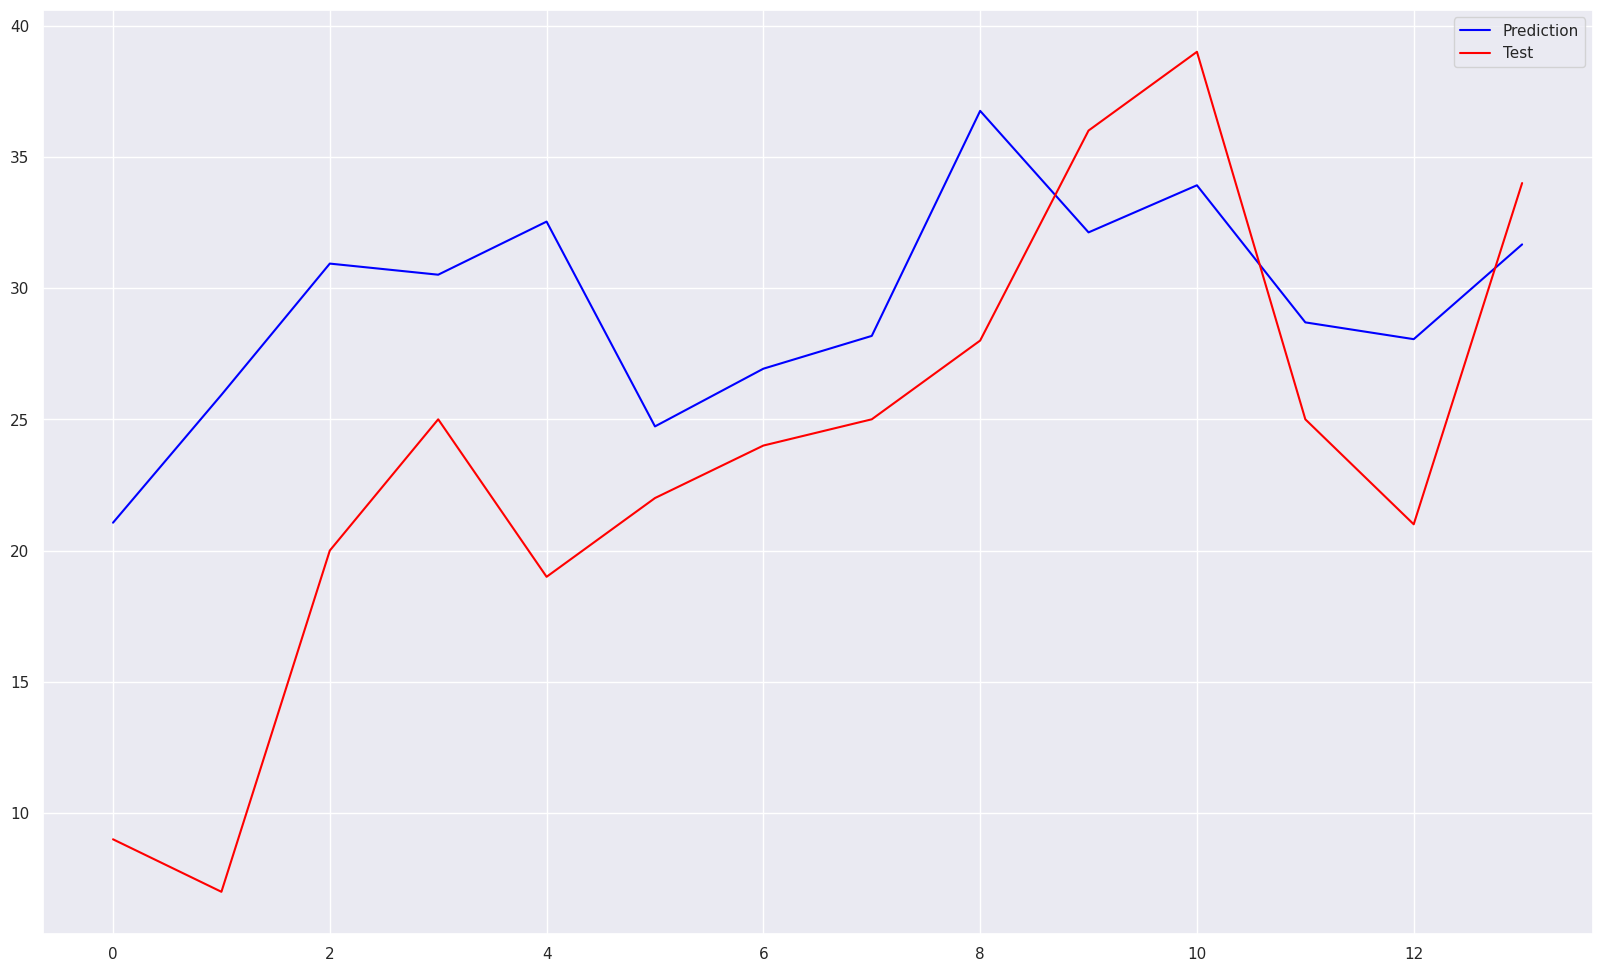

In [226]:
for i in range(tgv_y_pred.shape[0]):
    fig = plt.gcf(); fig.set_size_inches(20, 12);
    plt.plot(tgv_y_pred[i, :], c="blue", label="Prediction")
    plt.plot(tgv_y_test[i, :], c="red", label="Test")
#     plt.ylim(0, 430)
    plt.legend(loc='upper right')
    plt.show();

In [227]:
tgv_dl_error = np.mean(abs(tgv_y_pred - tgv_y_test))

In [228]:
tgv_base_error = np.mean(abs((df_25[['nb_cars']]-df_25[['nb_cars']].shift(14)).dropna()))[0]
tgv_base_error

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


6.6834239130434785

In [229]:
print(
    f"tgv model predicts with an average error of        {round(tgv_dl_error, 2)} cars"
    "\n"
    f"2 Weeks before predicts with an average error of  {round(tgv_base_error, 2)} cars"
)

tgv model predicts with an average error of        8.24 cars
2 Weeks before predicts with an average error of  6.68 cars


In [230]:
def plot_history(history):

    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: LOSS ---
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss')
    ax[0].set_ylabel('LOSS')
    ax[0].set_xlabel('EPOCH')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- METRICS: MAE ---

    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('Mean Absolute Error')
    ax[1].set_ylabel('LOSS')
    ax[1].set_xlabel('EPOCH')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    return ax

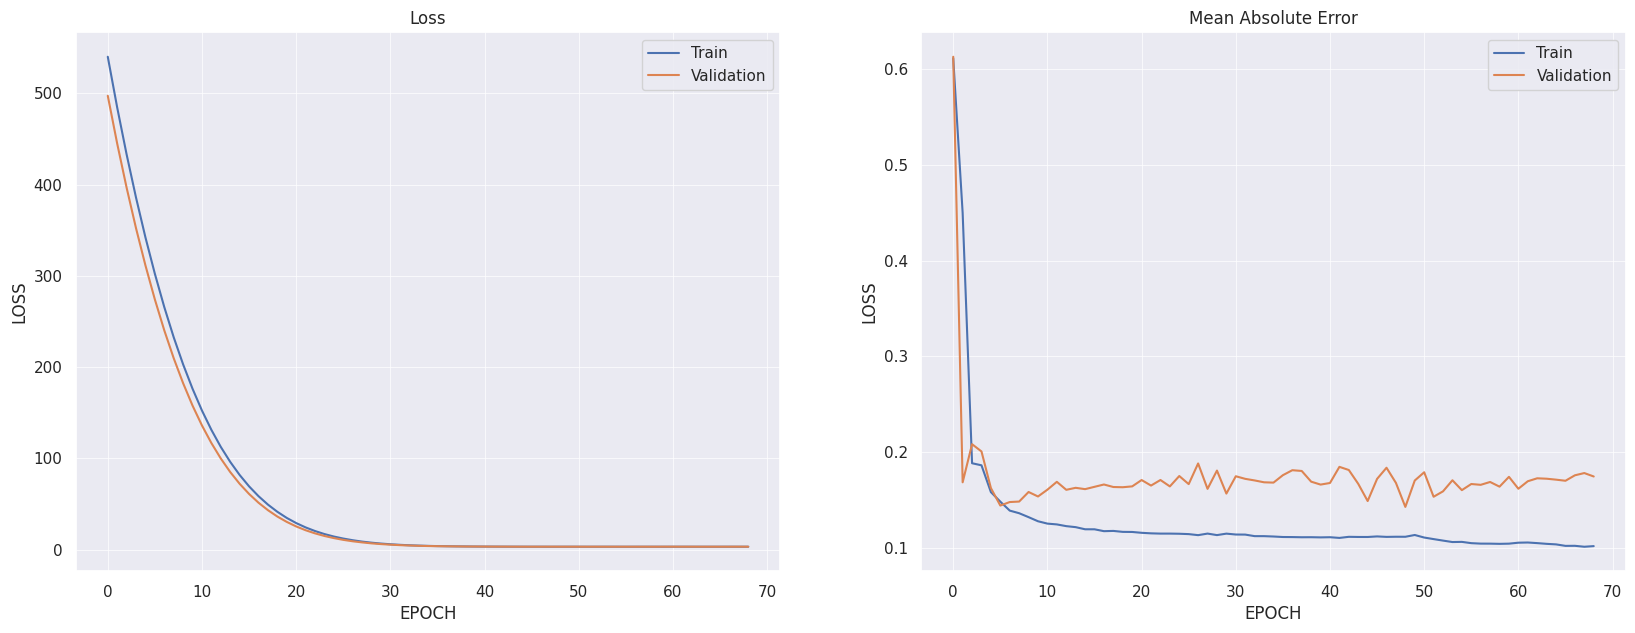

In [231]:
plot_history(tgv_history);

In [232]:
# Predict

In [233]:
df_25_last_56 = df_25.tail(56)
df_25_last_56

,nb_cars,nb_cars_cxl,nb_bookings,nb_bookings_cxl,hourly rate,WE package,1 week package,1 month package,other package,2 weeks package,...,12H à 15H,0H à 6H,18H à 24H,+24h,06:00 24:00,00:30 06:00,00:00 00:30,strike,holidays,vacation
date,,,,,,,,,,,,,,,,,,,,,
2023-04-26,30,3,9,0,12,0,14,4,0,0,...,8,2,4,30,0,0,0,0,0,1
2023-04-27,33,1,6,1,13,0,15,5,0,0,...,9,1,4,33,0,0,0,0,0,1
2023-04-28,25,1,23,1,5,1,14,5,0,0,...,9,1,3,25,0,0,0,0,0,1
2023-04-29,34,1,8,0,1,20,7,6,0,0,...,9,1,6,34,0,0,0,0,0,1
2023-04-30,38,1,1,0,2,26,6,4,0,0,...,9,1,4,38,0,0,0,0,0,1
2023-05-01,25,1,4,1,2,17,2,4,0,0,...,4,1,3,24,1,0,0,0,1,1
2023-05-02,10,1,10,0,0,3,2,5,0,0,...,0,1,0,10,0,0,0,0,0,1
2023-05-03,15,1,13,3,7,0,3,5,0,0,...,2,2,0,15,0,0,0,0,0,1
2023-05-04,23,4,12,0,14,0,4,5,0,0,...,3,1,0,23,0,0,0,0,0,1


In [234]:
# y normalize
tgv_y_scaler = MinMaxScaler()
tgv_y_scaler.fit(np.log(tgv_y_train))

tgv_y_train_scaled = tgv_y_scaler.transform(np.log(tgv_y_train))
tgv_y_test_scaled = tgv_y_scaler.transform(np.log(tgv_y_test))
tgv_y_val_scaled = tgv_y_scaler.transform(np.log(tgv_y_val))

# inverse
tgv_y_pred = tgv_model.predict(tgv_X_test)

tgv_y_pred = tgv_y_scaler.inverse_transform(tgv_y_pred)
tgv_y_pred = np.exp(tgv_y_pred)

1/1 [==============================] - 0s 29ms/step


In [235]:
df_25_last_56[['nb_cars']]

,nb_cars
date,
2023-04-26,30
2023-04-27,33
2023-04-28,25
2023-04-29,34
2023-04-30,38
2023-05-01,25
2023-05-02,10
2023-05-03,15
2023-05-04,23


In [237]:
#Predict for pocket #25
scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
y_scaler.fit(np.log(df_25_last_56[['nb_cars']]))
tgv_df_25_last_56_scaled = scaler.fit_transform(df_25_last_56)

pca = PCA(n_components=25).fit(tgv_df_25_last_56_scaled)
tgv_df_25_last_56_scaled_proj = pd.DataFrame(pca.transform(tgv_df_25_last_56_scaled))
tgv_df_25_last_56_scaled_proj.index = df_25_last_56.index


y_pred = tgv_model.predict(np.array(tgv_df_25_last_56_scaled_proj).reshape(1,56,25))

y_pred = y_scaler.inverse_transform(y_pred)
y_pred = np.exp(y_pred)
y_pred.tolist()

1/1 [==============================] - 0s 46ms/step


[[26.624147415161133,
  25.734298706054688,
  31.36496925354004,
  26.547622680664062,
  24.07948875427246,
  20.498367309570312,
  21.34337043762207,
  25.48324966430664,
  32.782470703125,
  35.0971565246582,
  30.8829345703125,
  27.56116485595703,
  22.769636154174805,
  30.375438690185547]]

In [238]:
def my_prediction(model):
  '''
  Returns a prediction of number of cars for 14 days
  '''

  #Scaling
  scaler = MinMaxScaler()
  y_scaler = MinMaxScaler()
  y_scaler.fit(np.log(df_25_last_56[['nb_cars']]))
  scaled_df = scaler.fit_transform(df_25_last_56)

  #PCA
  pca = PCA(n_components=25).fit(scaled_df)
  proj = pd.DataFrame(pca.transform(scaled_df))
  proj.index = df_25_last_56.index

  pred = model.predict(np.array(proj).reshape(1,56,25))
  pred = y_scaler.inverse_transform(pred)
  pred = np.exp(pred).tolist()

  return pred


In [239]:
my_prediction(tgv_model)

1/1 [==============================] - 0s 27ms/step


[[26.624147415161133,
  25.734298706054688,
  31.36496925354004,
  26.547622680664062,
  24.07948875427246,
  20.498367309570312,
  21.34337043762207,
  25.48324966430664,
  32.782470703125,
  35.0971565246582,
  30.8829345703125,
  27.56116485595703,
  22.769636154174805,
  30.375438690185547]]

In [240]:
tgv_model.save('df_25_model_3')

In [241]:
from google.colab import files
files.download('df_25_model2')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [242]:
from tensorflow import keras

In [243]:
new_model = keras.models.load_model('df_25_model_3')

# Show the model architecture
new_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 56, 200)           180800    
                                                                 
 lstm_41 (LSTM)              (None, 56, 200)           320800    
                                                                 
 lstm_42 (LSTM)              (None, 56, 200)           320800    
                                                                 
 lstm_43 (LSTM)              (None, 56, 200)           320800    
                                                                 
 lstm_44 (LSTM)              (None, 200)               320800    
                                                                 
 dense_8 (Dense)             (None, 14)                2814      
                                                                 
Total params: 1,466,814
Trainable params: 1,466,814
No

In [244]:
my_prediction(new_model)

1/1 [==============================] - 2s 2s/step


[[26.624147415161133,
  25.734298706054688,
  31.36496925354004,
  26.547622680664062,
  24.07948875427246,
  20.498367309570312,
  21.34337043762207,
  25.48324966430664,
  32.782470703125,
  35.0971565246582,
  30.8829345703125,
  27.56116485595703,
  22.769636154174805,
  30.375438690185547]]